In [1]:
from ecnet.datasets import load_mon, QSPRDataset
from sklearn.model_selection import train_test_split

smiles, targets = load_mon()
smiles_train, smiles_test, targets_train, targets_test = train_test_split(
    smiles, targets, test_size=0.2, random_state=24
)
dataset_train = QSPRDataset(smiles_train, targets_train, backend='alvadesc')
dataset_test = QSPRDataset(smiles_test, targets_test, backend='alvadesc')
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)

torch.Size([246, 5305]) torch.Size([62, 5305])


In [2]:
from ecnet.tasks.feature_selection import select_rfr

desc_idx, desc_imp = select_rfr(dataset_train, total_importance=0.95,
                                n_estimators=50, n_jobs=4)
dataset_train.set_desc_index(desc_idx)
dataset_test.set_desc_index(desc_idx)
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)
print(dataset_train.desc_names[:5], desc_imp[:5])

torch.Size([246, 306]) torch.Size([62, 306])
['GATS2m', 'SpMaxA_EA(bo)', 'SssCH2', 'CIC1', 'X3Av'] [0.2996945112861942, 0.07663901053198963, 0.07549392154472681, 0.03177151468749461, 0.016749533025309963]


In [3]:
from ecnet import ECNet

model = ECNet(dataset_train.desc_vals.shape[1], 1, 128, dataset_train.target_vals.shape[1])

In [4]:
train_loss, valid_loss = model.fit(
    dataset=dataset_train, valid_size=0.2, verbose=10,
    patience=100, epochs=1000, random_state=25,
    lr=0.01, lr_decay=1e-6, batch_size=48
)

Epoch: 0 | Train loss: 3061.4956129424427 | Valid loss: 9223372036854775807
Epoch: 10 | Train loss: 160.22841799989038 | Valid loss: 189.01295471191406
Epoch: 20 | Train loss: 161.80024454545003 | Valid loss: 182.3402862548828
Epoch: 30 | Train loss: 204.58766392299108 | Valid loss: 161.22836303710938
Epoch: 40 | Train loss: 127.66975371691646 | Valid loss: 147.3897705078125
Epoch: 50 | Train loss: 125.29937187506228 | Valid loss: 179.8015594482422
Epoch: 60 | Train loss: 128.44636745842135 | Valid loss: 175.72158813476562
Epoch: 70 | Train loss: 121.9212017448581 | Valid loss: 145.92050170898438
Epoch: 80 | Train loss: 133.40545809998804 | Valid loss: 154.7437744140625
Epoch: 90 | Train loss: 189.41848505759725 | Valid loss: 218.52980041503906
Epoch: 100 | Train loss: 85.57383992720624 | Valid loss: 146.8685760498047
Epoch: 110 | Train loss: 84.96891348702567 | Valid loss: 142.19400024414062
Epoch: 120 | Train loss: 91.07186877970793 | Valid loss: 153.1065673828125
Epoch: 130 | Train 

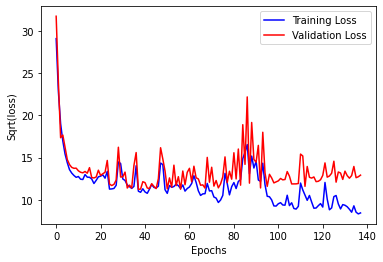

In [5]:
from math import sqrt
from matplotlib import pyplot as plt

train_loss = [sqrt(l) for l in train_loss][1:]
valid_loss = [sqrt(l) for l in valid_loss][1:]
epoch = [i for i in range(len(train_loss))]

plt.clf()
plt.xlabel('Epochs')
plt.ylabel('Sqrt(loss)')
plt.plot(epoch, train_loss, color='blue', label='Training Loss')
plt.plot(epoch, valid_loss, color='red', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [6]:
from sklearn.metrics import median_absolute_error, r2_score

y_hat_train = model(dataset_train.desc_vals).detach().numpy()
y_train = dataset_train.target_vals
train_mae = median_absolute_error(y_hat_train, y_train)
train_r2 = r2_score(y_hat_train, y_train)
y_hat_test = model(dataset_test.desc_vals).detach().numpy()
y_test = dataset_test.target_vals
test_mae = median_absolute_error(y_hat_test, y_test)
test_r2 = r2_score(y_hat_test, y_test)
print('Training median absolute error: {}'.format(train_mae))
print('Training r-squared coefficient: {}'.format(train_r2))
print('Testing median absolute error: {}'.format(test_mae))
print('Testing r-squared coefficient: {}'.format(test_r2))

Training median absolute error: 7.573198318481445
Training r-squared coefficient: 0.5562678992883007
Testing median absolute error: 7.641349792480469
Testing r-squared coefficient: 0.6240488373106693


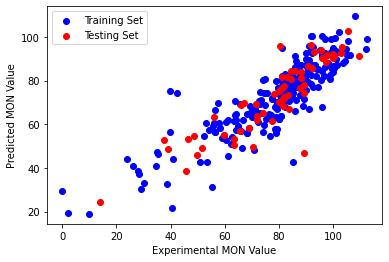

In [7]:
plt.clf()
plt.xlabel('Experimental MON Value')
plt.ylabel('Predicted MON Value')
plt.scatter(y_train, y_hat_train, color='blue', label='Training Set')
plt.scatter(y_test, y_hat_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()